Epoch    1/500 - Loss: 1.1006 - Acc: 33.60%
Epoch  100/500 - Loss: 0.7255 - Acc: 64.80%
Epoch  200/500 - Loss: 0.7005 - Acc: 71.00%
Epoch  300/500 - Loss: 0.6262 - Acc: 69.00%
Epoch  400/500 - Loss: 0.6446 - Acc: 66.40%
Epoch  500/500 - Loss: 0.5929 - Acc: 70.60%

Final training accuracy: 70.60%


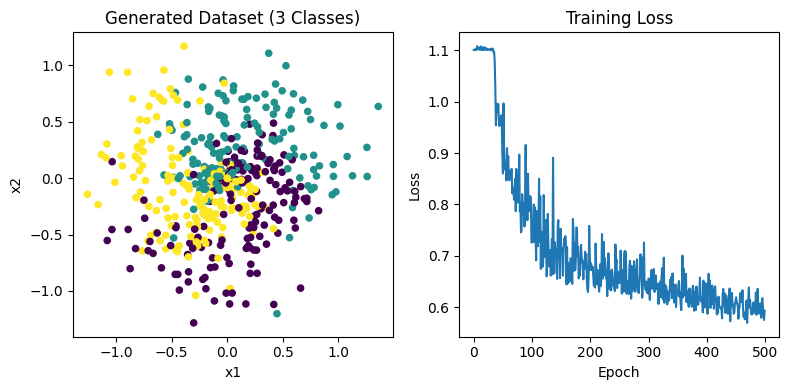

In [2]:

import numpy as np
import matplotlib.pyplot as plt


# 1. Generate dataset (500 pts, 3 classes)

np.random.seed(42)
num_points = 500
num_classes = 3
points_per_class = num_points // num_classes

X = np.zeros((num_points, 2))
y = np.zeros(num_points, dtype=np.int64)

for class_label in range(num_classes):
    ix = range(class_label * points_per_class, (class_label + 1) * points_per_class)
    r = np.linspace(0.0, 1, points_per_class) + 0.2 * np.random.randn(points_per_class)
    t = np.linspace(class_label * 4, (class_label + 1) * 4, points_per_class) + 0.5 * np.random.randn(points_per_class)
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = class_label

# Shuffle data
perm = np.random.permutation(num_points)
X = X[perm]
y = y[perm]

# One-hot encoding
Y_onehot = np.zeros((num_points, num_classes))
Y_onehot[np.arange(num_points), y] = 1


# 2. Helper functions

def softmax(z):
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z_stable)
    return exp / np.sum(exp, axis=1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def cross_entropy_loss(probs, labels_onehot):
    eps = 1e-12
    probs_clipped = np.clip(probs, eps, 1.0 - eps)
    return -np.mean(np.sum(labels_onehot * np.log(probs_clipped), axis=1))

def accuracy(preds, labels):
    return np.mean(preds == labels)


# 3. Initialize network parameters (3 layers)

D = X.shape[1]  # input dimension = 2
H1 = 32         # first hidden layer
H2 = 16         # second hidden layer
C = num_classes # output classes

rng = np.random.RandomState(1)
W1 = 0.01 * rng.randn(D, H1); b1 = np.zeros((1, H1))
W2 = 0.01 * rng.randn(H1, H2); b2 = np.zeros((1, H2))
W3 = 0.01 * rng.randn(H2, C); b3 = np.zeros((1, C))


# 4. Training parameters

learning_rate = 1.0
num_epochs = 500
batch_size = 64
num_batches = int(np.ceil(num_points / batch_size))

loss_history = []


# 5. Training loop

for epoch in range(1, num_epochs + 1):
    perm = np.random.permutation(num_points)
    X_shuffled = X[perm]
    Y_shuffled = Y_onehot[perm]
    y_shuffled = y[perm]
    epoch_loss = 0.0

    for b in range(num_batches):
        start = b * batch_size
        end = min(start + batch_size, num_points)
        xb = X_shuffled[start:end]
        yb_onehot = Y_shuffled[start:end]
        n_b = xb.shape[0]

        # Forward pass
        z1 = xb.dot(W1) + b1
        a1 = relu(z1)
        z2 = a1.dot(W2) + b2
        a2 = relu(z2)
        logits = a2.dot(W3) + b3
        probs = softmax(logits)

        # Compute loss
        loss = cross_entropy_loss(probs, yb_onehot)
        epoch_loss += loss * n_b

        # Backpropagation
        dlogits = (probs - yb_onehot) / n_b
        dW3 = a2.T.dot(dlogits)
        db3 = np.sum(dlogits, axis=0, keepdims=True)

        da2 = dlogits.dot(W3.T)
        dz2 = da2 * relu_grad(z2)
        dW2 = a1.T.dot(dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = dz2.dot(W2.T)
        dz1 = da1 * relu_grad(z1)
        dW1 = xb.T.dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Parameter updates (SGD)
        W3 -= learning_rate * dW3; b3 -= learning_rate * db3
        W2 -= learning_rate * dW2; b2 -= learning_rate * db2
        W1 -= learning_rate * dW1; b1 -= learning_rate * db1

    epoch_loss /= num_points
    loss_history.append(epoch_loss)

    if epoch % 100 == 0 or epoch == 1:
        # Evaluate training accuracy
        z1_all = X.dot(W1) + b1
        a1_all = relu(z1_all)
        z2_all = a1_all.dot(W2) + b2
        a2_all = relu(z2_all)
        logits_all = a2_all.dot(W3) + b3
        probs_all = softmax(logits_all)
        preds_all = np.argmax(probs_all, axis=1)
        acc = accuracy(preds_all, y)
        print(f"Epoch {epoch:4d}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {acc*100:.2f}%")


# 6. Final accuracy and plots

z1_all = X.dot(W1) + b1
a1_all = relu(z1_all)
z2_all = a1_all.dot(W2) + b2
a2_all = relu(z2_all)
logits_all = a2_all.dot(W3) + b3
probs_all = softmax(logits_all)
preds_all = np.argmax(probs_all, axis=1)
final_acc = accuracy(preds_all, y)
print(f"\nFinal training accuracy: {final_acc*100:.2f}%")


# 7. Visualizations

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Generated Dataset (3 Classes)")
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
plt.xlabel("x1")
plt.ylabel("x2")

plt.subplot(1, 2, 2)
plt.title("Training Loss")
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

